In [32]:
# Developer: Brady Lange
# 11/08/2019
# Description:

from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import xlrd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Parameters

In [35]:
startdate = sbean_cont_mar["Date"][0]
# startdate = sbean_cont_may["Date"][0]
# startdate = sbean_cont_july["Date"][0]
window_length = 10
encoding_dim = 3
epochs = 100
test_samples = 25

## Utils

In [33]:
def mkdate(ts):
    return datetime.datetime.fromtimestamp(
        int(ts)
    ).strftime('%Y-%M-%d')

def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 200))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

In [38]:
# TODO: CONVERT DATES TO STRINGS TO BE CONVERTED TO TIMESTAMPS
# TODO: SEPERATE DATASETS (THEY'RE NOT THE SAME!)

# Load active contracts for March dataset
sbean_cont_mar = pd.read_excel(r"./data/active_soybean_contracts_for_march_2020.xlsx", sheet_name = "ZS_H_2020.CSV", skiprows = 3)
# Load active contracts for May dataset
sbean_cont_may = pd.read_excel(r"./data/active_soybean_contracts_for_may_2020.xlsx", sheet_name = "ZS_K_2020.CSV", skiprows = 3)
# Load active contracts for July dataset
sbean_cont_july = pd.read_excel(r"./data/active_soybean_contracts_for_july_2020.xlsx", sheet_name = "ZS_N_2020.CSV", skiprows = 3)


sbean_cont_mar.sort_values(by = "Date", inplace = True)
sbean_cont_may.sort_values(by = "Date", inplace = True)
sbean_cont_july.sort_values(by = "Date", inplace = True)

# sbean_cont_all.insert(0, "Year", sbean_cont_all["Date"].dt.year)
# sbean_cont_all.insert(1, "Month", sbean_cont_all["Date"].dt.month)
# sbean_cont_all.insert(2, "Day", sbean_cont_all["Date"].dt.day)
# sbean_cont_all.insert(3, "Avg_Price", 
#                       (sbean_cont_all["Open"] + sbean_cont_all["High"] 
#                       + sbean_cont_all["Low"] + sbean_cont_all["Close"]) 
#                       / sbean_cont_all[["Open", "High", "Low", "Close"]].shape[1])
sbean_cont_mar.drop(["Open", "High", "Low"], axis = 1, inplace = True)
sbean_cont_may.drop(["Open", "High", "Low"], axis = 1, inplace = True)
sbean_cont_july.drop(["Open", "High", "Low"], axis = 1, inplace = True)

#sbean_cont_all[["Year", "Month", "Day"]] = sbean_cont_all[["Year", "Month", "Day"]].astype(str)

sbean_cont_mar["Date"] = sbean_cont_mar["Date"].astype(str)
sbean_cont_may["Date"] = sbean_cont_may["Date"].astype(str)
sbean_cont_july["Date"] = sbean_cont_july["Date"].astype(str)

## Datasets retrieval & transformation

In [39]:
# get data
start_timestamp = time.mktime(datetime.datetime.strptime(startdate, "%Y-%M-%d").timetuple())
end_timestamp = time.mktime(datetime.datetime.strptime(max(sbean_cont_mar["Date"]), "%Y-%M-%d").timetuple())

days = []
for day in sbean_cont_mar["Date"]:
    days.append(time.mktime(datetime.datetime.strptime(day, "%Y-%M-%d").timetuple()))
sbean_cont_mar.insert(0, "Timestamp", days)
sbean_cont_mar.drop(["Date"], axis = 1, inplace = True)

sbean_cont_mar = sbean_cont_mar.to_numpy().tolist()

one_week = 3600*24*7 # s
one_day = 3600*24 # s
weeks = list(np.arange(start_timestamp, end_timestamp, one_week))
days_recorded = (datetime.datetime.fromtimestamp(end_timestamp)-datetime.datetime.fromtimestamp(start_timestamp)).days
print("days_recorded ", days_recorded)
data = []
if not os.path.isfile("data.pickle"):
    for i in range(1, len(weeks)):
        start_weekday = mkdate(weeks[i-1])
        end_weekday = mkdate(weeks[i]-one_day)
        print(start_weekday, end_weekday)
        sbean_cont_mar.sort(key=lambda x: x[0])
        for pricepoint in sbean_cont_mar:
            if pricepoint[0] >= weeks[i-1] and pricepoint[0] < (weeks[i]-one_day):
                data.append([int(pricepoint[0]), pricepoint[1]])
                
    pickle.dump(data, open("./data.pickle", "wb"))
else:
    data = pickle.load(open("./data.pickle", "rb"))

df = pd.DataFrame(np.array(data)[:,1], columns=['price'])
df['pct_change'] = df.price.pct_change()
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))

scaler = MinMaxScaler()
x_train_nonscaled = np.array([df['log_ret'].values[i-window_length:i].reshape(-1, 1) for i in tqdm(range(window_length+1,len(df['log_ret'])))])
x_train = np.array([scaler.fit_transform(df['log_ret'].values[i-window_length:i].reshape(-1, 1)) for i in tqdm(range(window_length+1,len(df['log_ret'])))])

x_test = x_train[-test_samples:]
x_train = x_train[:-test_samples]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

days_recorded  745
2017-11-14 2017-11-20
2017-11-21 2017-11-27
2017-11-28 2017-11-03
2017-11-04 2017-11-10
2017-11-11 2017-11-17
2017-11-18 2017-11-24
2017-11-25 2017-11-03
2017-11-04 2017-11-10
2017-11-11 2017-11-17
2017-11-18 2017-11-24
2017-11-25 2017-11-31
2017-11-01 2017-11-07
2017-11-08 2017-11-14
2017-11-15 2017-11-21
2017-11-22 2017-11-28
2017-11-29 2017-11-05
2017-11-06 2017-11-12
2017-11-13 2017-11-19
2017-11-20 2017-11-26
2017-11-27 2017-11-02
2017-11-03 2017-11-09
2017-11-10 2017-11-16
2017-11-17 2017-11-23
2017-11-24 2017-11-30
2017-11-01 2017-11-07
2017-11-08 2017-11-14
2017-11-15 2017-11-21
2017-11-22 2017-11-28
2017-11-29 2017-11-04
2017-11-05 2017-11-11
2017-11-12 2017-11-18
2017-11-19 2017-11-25
2017-11-26 2017-11-01
2017-11-02 2017-11-08
2017-11-09 2017-11-15
2017-11-16 2017-11-22
2017-11-23 2017-11-29
2017-11-30 2017-11-06
2017-11-07 2017-11-13
2017-11-14 2017-11-20
2017-11-21 2017-11-27
2017-11-28 2017-11-03
2017-11-04 2017-11-10
2017-11-11 2017-11-17
2017-11-18 20

100%|██████████| 345/345 [00:00<00:00, 2159.12it/s]


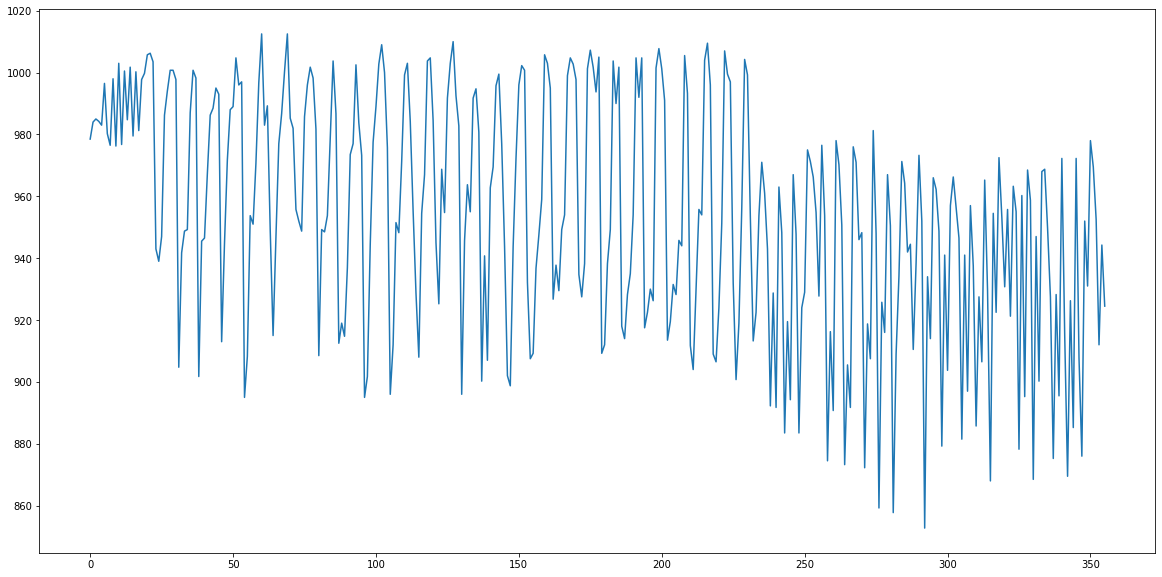

In [40]:
plt.figure(figsize=(20,10))
plt.plot(np.array(data)[:,1])

In [41]:
print("Percentage of test data: {}%".format((test_samples/len(x_train))*100))

Percentage of test data: 7.8125%


In [42]:
len(x_train)

320

## Simple feed-forward autoencoder

In [43]:
x_train_simple = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# this is our input placeholder
input_window = Input(shape=(window_length,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_window)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(window_length, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_14 (Dense)             (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Train on 320 samples, validate on 25 samples
Epoch 1/100
320/320 [==============================] - 0s 774us/step - loss: 0.6939 - val_loss: 0.6857
Epoch 2/100
320/320 [==============================] - 0s 12us/step - loss: 0.6937 - val_loss: 0.6857
Epoch 3/100
320/320 [==============================] - 0s 12us/step - loss: 0.6936 - val_loss: 0.6857
Epoch 4/100
320/320 [===================

Epoch 73/100
320/320 [==============================] - 0s 12us/step - loss: 0.6839 - val_loss: 0.6817
Epoch 74/100
320/320 [==============================] - 0s 12us/step - loss: 0.6838 - val_loss: 0.6816
Epoch 75/100
320/320 [==============================] - 0s 100us/step - loss: 0.6837 - val_loss: 0.6815
Epoch 76/100
320/320 [==============================] - 0s 12us/step - loss: 0.6835 - val_loss: 0.6814
Epoch 77/100
320/320 [==============================] - 0s 12us/step - loss: 0.6834 - val_loss: 0.6813
Epoch 78/100
320/320 [==============================] - 0s 12us/step - loss: 0.6833 - val_loss: 0.6812
Epoch 79/100
320/320 [==============================] - 0s 12us/step - loss: 0.6832 - val_loss: 0.6811
Epoch 80/100
320/320 [==============================] - 0s 12us/step - loss: 0.6831 - val_loss: 0.6810
Epoch 81/100
320/320 [==============================] - 0s 12us/step - loss: 0.6829 - val_loss: 0.6809
Epoch 82/100
320/320 [==============================] - 0s 12us/step - l

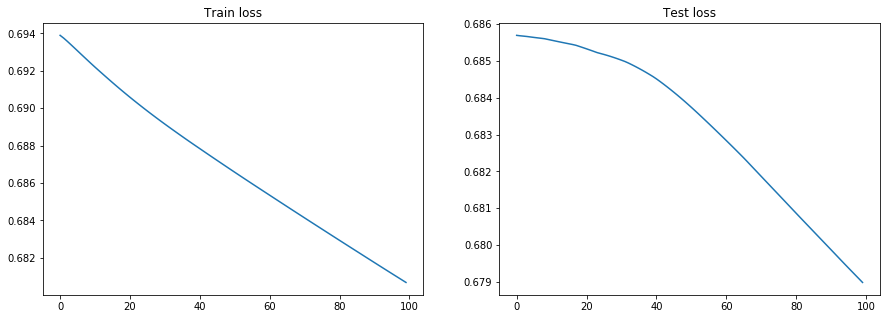

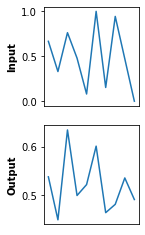

In [44]:
plot_history(history)
plot_examples(x_test_simple, decoded_stocks)

## Deep autoencoder

In [10]:
x_train_deep = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 66        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 24        
_________________________________________________________________
batch_normalization_2 (Batch (None, 6)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                70  

Epoch 68/100
325/325 [==============================] - 0s 25us/step - loss: 0.7057 - val_loss: 0.6991
Epoch 69/100
325/325 [==============================] - 0s 12us/step - loss: 0.7052 - val_loss: 0.6992
Epoch 70/100
325/325 [==============================] - 0s 12us/step - loss: 0.7047 - val_loss: 0.6993
Epoch 71/100
325/325 [==============================] - 0s 12us/step - loss: 0.7043 - val_loss: 0.6994
Epoch 72/100
325/325 [==============================] - 0s 25us/step - loss: 0.7038 - val_loss: 0.6995
Epoch 73/100
325/325 [==============================] - 0s 12us/step - loss: 0.7033 - val_loss: 0.6995
Epoch 74/100
325/325 [==============================] - 0s 12us/step - loss: 0.7028 - val_loss: 0.6996
Epoch 75/100
325/325 [==============================] - 0s 25us/step - loss: 0.7024 - val_loss: 0.6997
Epoch 76/100
325/325 [==============================] - 0s 12us/step - loss: 0.7019 - val_loss: 0.6998
Epoch 77/100
325/325 [==============================] - 0s 12us/step - lo

In [ ]:
from sklearn.metrics import mean_squared_error

orig = scaler.inverse_transform(x_test.reshape(100, 10))
# orig = exp(orig)
# min_x_test = np.min(orig)
# max_x_test = np.max(orig)

dec = scaler.inverse_transform(decoded_stocks)
# dec = exp(dec)

# Relative root mean squared error
sqrt(mean_squared_error(orig, dec)) #/ (max_x_test - min_x_test)

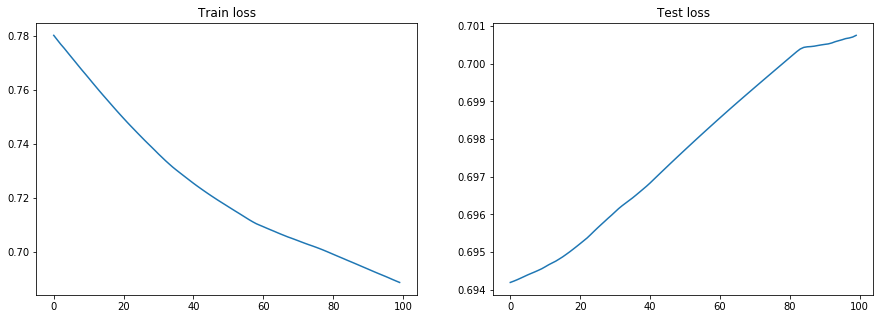

In [11]:
plot_history(history)

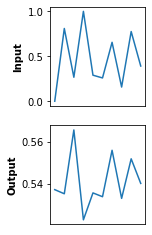

In [12]:
plot_examples(x_test_deep, decoded_stocks)

## 1D Convolutional autoencoder

In [13]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 16)            64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 1)              49        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 1)              0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 1)              4         
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 6, 1)              0   

Epoch 64/100
325/325 [==============================] - 0s 37us/step - loss: 0.6865 - val_loss: 0.7019
Epoch 65/100
325/325 [==============================] - 0s 49us/step - loss: 0.6864 - val_loss: 0.7021
Epoch 66/100
325/325 [==============================] - 0s 37us/step - loss: 0.6864 - val_loss: 0.7023
Epoch 67/100
325/325 [==============================] - 0s 37us/step - loss: 0.6863 - val_loss: 0.7025
Epoch 68/100
325/325 [==============================] - 0s 37us/step - loss: 0.6863 - val_loss: 0.7027
Epoch 69/100
325/325 [==============================] - 0s 49us/step - loss: 0.6862 - val_loss: 0.7029
Epoch 70/100
325/325 [==============================] - 0s 37us/step - loss: 0.6862 - val_loss: 0.7031
Epoch 71/100
325/325 [==============================] - 0s 37us/step - loss: 0.6861 - val_loss: 0.7033
Epoch 72/100
325/325 [==============================] - 0s 37us/step - loss: 0.6861 - val_loss: 0.7035
Epoch 73/100
325/325 [==============================] - 0s 37us/step - lo

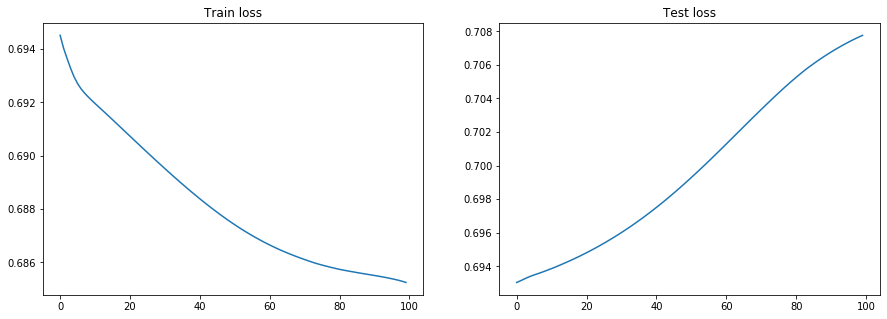

In [14]:
plot_history(history)

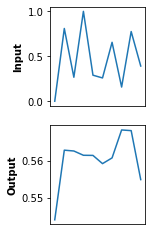

In [15]:
plot_examples(x_test_deep, decoded_stocks)

## LSTM (recurrent neural networks) autoencoder

In [16]:
inputs = Input(shape=(window_length, 1))
encoded = LSTM(encoding_dim)(inputs)

decoded = RepeatVector(window_length)(encoded)
decoded = LSTM(1, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = sequence_autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = sequence_autoencoder.predict(x_test)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 10, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3)                 60        
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 3)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 1)             20        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
Train on 325 samples, validate on 25 samples
Epoch 1/100
325/325 [==============================] - 1s 2ms/step - loss: 8.6287 - val_loss: 7.1015
Epoch 2/100
325/325 [==============================] - 0s 61us/step - loss: 8.5694 - val_loss: 6.6763
Epoch 3/100
3

Epoch 72/100
325/325 [==============================] - 0s 49us/step - loss: 1.5154 - val_loss: 1.3313
Epoch 73/100
325/325 [==============================] - 0s 61us/step - loss: 1.5104 - val_loss: 1.3273
Epoch 74/100
325/325 [==============================] - 0s 49us/step - loss: 1.5054 - val_loss: 1.3233
Epoch 75/100
325/325 [==============================] - 0s 61us/step - loss: 1.5005 - val_loss: 1.3193
Epoch 76/100
325/325 [==============================] - 0s 49us/step - loss: 1.4956 - val_loss: 1.3154
Epoch 77/100
325/325 [==============================] - 0s 49us/step - loss: 1.4907 - val_loss: 1.3115
Epoch 78/100
325/325 [==============================] - 0s 61us/step - loss: 1.4858 - val_loss: 1.3076
Epoch 79/100
325/325 [==============================] - 0s 49us/step - loss: 1.4810 - val_loss: 1.3038
Epoch 80/100
325/325 [==============================] - 0s 49us/step - loss: 1.4762 - val_loss: 1.2999
Epoch 81/100
325/325 [==============================] - 0s 61us/step - lo

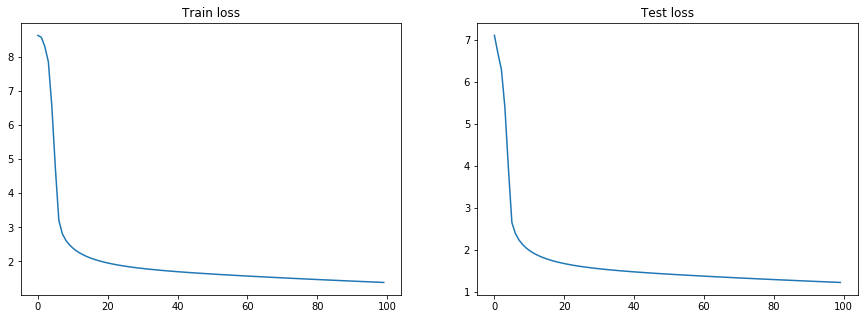

In [17]:
plot_history(history)

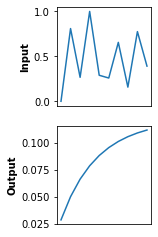

In [18]:
plot_examples(x_test, decoded_stocks)

## Simple AE + augmention with synthetic data

In [19]:
synthesized = []
required_nums = [0, 1]
optional_nums = list(np.arange(0.1, 0.9, 0.1))
for i in tqdm(range(100000)):
    combo = list(np.random.choice(optional_nums, 8))+required_nums
    np.random.shuffle(combo)
    synthesized.append(combo)

100%|██████████| 100000/100000 [00:04<00:00, 21151.27it/s]


In [20]:
x_train_simple = np.concatenate((x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))),synthesized))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


input_window = Input(shape=(window_length,))
encoded = Dense(encoding_dim, activation='relu')(input_window)
decoded = Dense(window_length, activation='sigmoid')(encoded)
autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_8 (Dense)              (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Train on 100325 samples, validate on 25 samples
Epoch 1/100
100325/100325 [==============================] - ETA: 9s - loss: 0.690 - ETA: 0s - loss: 0.689 - ETA: 0s - loss: 0.688 - ETA: 0s - loss: 0.686 - 0s 3us/step - loss: 0.6856 - val_loss: 0.6862
Epoch 2/100
100325/100325 [==============================] - ETA: 0s - loss: 0.678 - ETA: 0s - loss: 0.677 - ETA: 0s - loss: 0.676 - ETA: 0s -

Epoch 34/100
100325/100325 [==============================] - ETA: 0s - loss: 0.628 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - 0s 2us/step - loss: 0.6267 - val_loss: 0.6207
Epoch 35/100
100325/100325 [==============================] - ETA: 0s - loss: 0.627 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - 0s 2us/step - loss: 0.6266 - val_loss: 0.6204
Epoch 36/100
100325/100325 [==============================] - ETA: 0s - loss: 0.625 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - 0s 3us/step - loss: 0.6265 - val_loss: 0.6204
Epoch 37/100
100325/100325 [==============================] - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - 0s 2us/step - loss: 0.6264 - val_loss: 0.6201
Epoch 38/100
100325/100325 [==============================] - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.626 - ET

100325/100325 [==============================] - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - 0s 3us/step - loss: 0.6223 - val_loss: 0.6012
Epoch 74/100
100325/100325 [==============================] - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - 0s 2us/step - loss: 0.6223 - val_loss: 0.6007
Epoch 75/100
100325/100325 [==============================] - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - 0s 2us/step - loss: 0.6222 - val_loss: 0.6000
Epoch 76/100
100325/100325 [==============================] - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - 0s 2us/step - loss: 0.6221 - val_loss: 0.5993
Epoch 77/100
100325/100325 [==============================] - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss:

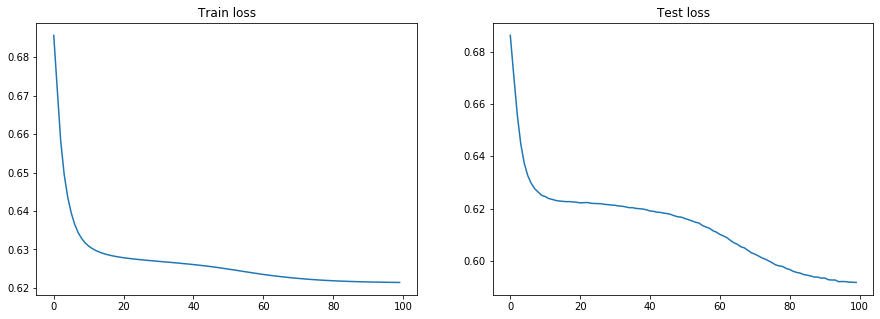

In [21]:
plot_history(history)

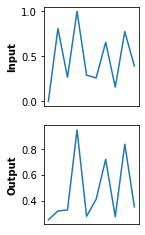

In [22]:
plot_examples(x_test_simple, decoded_stocks)

## Deep autoencoder + synthetic data

In [45]:
x_train_deep = np.concatenate((x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))),synthesized))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)
autoencoder = Model(input_window, decoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 66        
_________________________________________________________________
batch_normalization_5 (Batch (None, 6)                 24        
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 24        
_________________________________________________________________
batch_normalization_6 (Batch (None, 6)                 24        
_________________________________________________________________
dense_18 (Dense)             (None, 10)                70 

100320/100320 [==============================] - ETA: 0s - loss: 0.619 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - 0s 5us/step - loss: 0.6215 - val_loss: 0.5927
Epoch 22/100
100320/100320 [==============================] - ETA: 0s - loss: 0.619 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - 0s 4us/step - loss: 0.6214 - val_loss: 0.5923
Epoch 23/100
100320/100320 [==============================] - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - 0s 4us/step - loss: 0.6215 - val_loss: 0.5922
Epoch 24/100
100320/100320 [==============================] - ETA: 0s - loss: 0.624 - ETA

Epoch 47/100
100320/100320 [==============================] - ETA: 0s - loss: 0.618 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - 0s 5us/step - loss: 0.6215 - val_loss: 0.5920
Epoch 48/100
100320/100320 [==============================] - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - 0s 4us/step - loss: 0.6214 - val_loss: 0.5920
Epoch 49/100
100320/100320 [==============================] - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - 0s 5us/step - loss: 0.6214 - val_loss: 0.5923
Epoch 50/100
100320/100320 [========================

100320/100320 [==============================] - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - 0s 4us/step - loss: 0.6214 - val_loss: 0.5922
Epoch 73/100
100320/100320 [==============================] - ETA: 1s - loss: 0.620 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - 0s 4us/step - loss: 0.6214 - val_loss: 0.5922
Epoch 74/100
100320/100320 [==============================] - ETA: 1s - loss: 0.619 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - 1s 6us/step - loss: 0.6214 - val_loss: 0.5915
Epoch 75/100
1003

100320/100320 [==============================] - ETA: 1s - loss: 0.619 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - 0s 5us/step - loss: 0.6214 - val_loss: 0.5922
Epoch 97/100
100320/100320 [==============================] - ETA: 0s - loss: 0.617 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - 0s 4us/step - loss: 0.6214 - val_loss: 0.5927
Epoch 98/100
100320/100320 [==============================] - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - 0s 5us/step - loss: 0.6214 - val_loss: 0.5914
Epoch 99/100
100320/100320 [=============

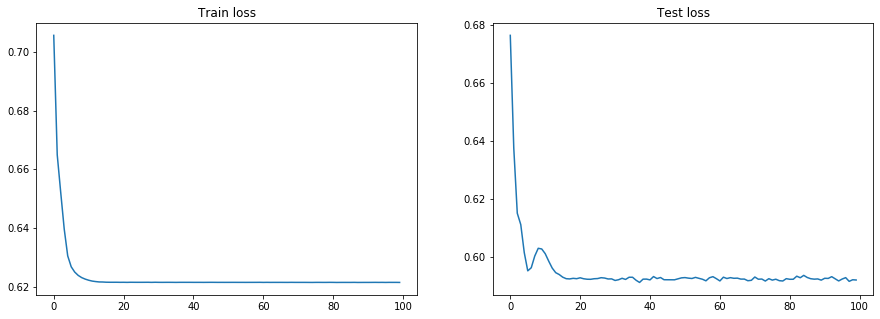

In [46]:
plot_history(history)

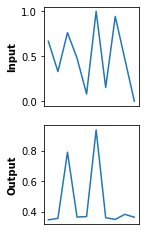

In [47]:
plot_examples(x_test_simple, decoded_stocks)